In [1]:
import pandas as pd

In [2]:
gas_sand = pd.read_csv('erosion in gas-sand conditions.csv')
multiphase_flow = pd.read_csv("erosion under multiphase flow conditions.csv")

gas_sand['splitter'] = 0
multiphase_flow['splitter']=1

In [3]:

dataset = pd.concat([multiphase_flow,gas_sand], ignore_index=True)


In [4]:
#drop completely empty rows (not taking into account the splitter column cuz we just added it manually)

dataset.dropna(how='all', subset=[col for col in dataset.columns if col != 'splitter'], inplace= True)

In [5]:
#filling nulls with zeros 
cols_to_fill = ['Liquid Viscosity (cP)','Liquid Superficial Velocity (m/s)']
dataset[cols_to_fill] = dataset[cols_to_fill].fillna(0)

In [6]:
# drop unimportant column
dataset.drop(columns='Reference', inplace=True)

In [7]:
dataset['Pipe Wall Material'].replace({
    'Cs-100_95':'CS-100_95'
},
  inplace= True                                    
                                      )

C:\Users\abdul\AppData\Local\Temp\ipykernel_2708\2457097583.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['Pipe Wall Material'].replace({


In [8]:
Predicted_Erosion = dataset['Predicted Erosion (mm/kg)']
Measured_Erosion = dataset['Measured Erosion (mm/kg)']
Error_col = dataset['Error (%)']
dataset.drop(columns=['Error (%)', 'Predicted Erosion (mm/kg)'], inplace=True, axis=1)


In [9]:

dataset_first_drop = pd.get_dummies(dataset,  drop_first= True,columns=['Pipe Wall Material'], dtype=int)
dataset_trees = pd.get_dummies(dataset,  drop_first= False,columns=['Pipe Wall Material'], dtype=int)

In [10]:
import numpy as np
X_log = dataset_first_drop.drop(columns='Measured Erosion (mm/kg)')
X_trees = dataset_trees.drop(columns='Measured Erosion (mm/kg)')
X = dataset_trees.drop(columns=['Measured Erosion (mm/kg)','splitter'])
Y_log = dataset_first_drop['Measured Erosion (mm/kg)']
Y_trees = dataset_trees['Measured Erosion (mm/kg)']
Y = dataset_trees['Measured Erosion (mm/kg)']
Xg = dataset_trees.drop(columns=['Measured Erosion (mm/kg)'])

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train_first_drop, X_test_first_drop, Y_train_first_drop, Y_test_first_drop = train_test_split(X_log, Y_log, test_size=0.5, random_state= 42)
X_train_trees, X_test_trees, Y_train_trees, Y_test_trees = train_test_split(X_trees, Y_trees,test_size=0.5,random_state=42 )
X_train_first_drop_nn_LR, X_test_first_drop_nn_LR, Y_train_first_drop_nn_LR, Y_test_first_drop_nn_LR = train_test_split(X_log, Y_log, test_size=0.5, stratify=dataset_first_drop['splitter'], random_state= 42)


X_train_first_drop = X_train_first_drop.drop(columns='splitter')
X_test_first_drop = X_test_first_drop.drop(columns='splitter')

X_train_trees = X_train_trees.drop(columns='splitter')
X_test_trees = X_test_trees.drop(columns='splitter')

X_train, X_test, Y_train, Y_test = train_test_split(Xg, Y, test_size=0.5, stratify=dataset['splitter'], random_state= 42)
X_train_first_drop_nn_LR=X_train_first_drop_nn_LR.drop(columns=['splitter'] )
X_test_first_drop_nn_LR=X_test_first_drop_nn_LR.drop(columns=['splitter'] ) 

X_train = X_train.drop(columns='splitter')
X_test= X_test.drop(columns='splitter')

X_train_SVR = X_train_first_drop.drop(columns=['Pipe Wall Material_CS-100_130',	'Pipe Wall Material_CS-100_167',	'Pipe Wall Material_CS-100_95',	'Pipe Wall Material_SS-316'])
X_test_SVR = X_test_first_drop.drop(columns=['Pipe Wall Material_CS-100_130',	'Pipe Wall Material_CS-100_167',	'Pipe Wall Material_CS-100_95',	'Pipe Wall Material_SS-316'])

In [12]:


scaler = StandardScaler()

X_train_first_drop_scaled = scaler.fit_transform(X_train_first_drop)
X_test_first_drop_scaled = scaler.transform(X_test_first_drop)
X_train_SVR_scaled = scaler.fit_transform(X_train_SVR)
X_test_SVR_scaled = scaler.transform(X_test_SVR)

X_train_first_drop_scaled_nn_LR = scaler.fit_transform(X_train_first_drop_nn_LR)
X_test_first_drop_scaled_nn_LR = scaler.transform(X_test_first_drop_nn_LR)



In [13]:
#import seaborn as sns
#import matplotlib.pyplot as plt

#correlation = dataset[['Pipe Diameter (m)',	'Particle Size (µm)',	'Liquid Viscosity (cP)',	'Liquid Superficial Velocity (m/s)',	'Gas Superficial Velocity (m/s)','Measured Erosion (mm/kg)']].corr()
#plt.figure(figsize=(10, 6))
#sns.heatmap(correlation[['Measured Erosion (mm/kg)']].sort_values(by='Measured Erosion (mm/kg)', ascending=False), annot=True, cmap='coolwarm')
#plt.title('Feature Correlation with Measured Erosion')
#plt.show()


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error

# train
lr_model = LinearRegression()
lr_model.fit(X_train_first_drop_scaled_nn_LR, Y_train_first_drop_nn_LR)

# predict
Y_pred_lr = lr_model.predict(X_test_first_drop_scaled_nn_LR)
# evaluate
mse_lr = mean_squared_error(Y_test_first_drop_nn_LR, Y_pred_lr)
r2_lr = r2_score(Y_test_first_drop_nn_LR, Y_pred_lr)

print("Linear Regression MAE:",mean_absolute_error(Y_test_first_drop_nn_LR, Y_pred_lr))
print("Linear Regression R²:", r2_lr)
print("Linear Regression MSE:", mse_lr)


Linear Regression MAE: 0.01397550646717738
Linear Regression R²: 0.7923348266430954
Linear Regression MSE: 0.00032248238844623765


In [16]:
from sklearn.ensemble import RandomForestRegressor

# train
rf_model = RandomForestRegressor(random_state=42, )
rf_model.fit(X_train_trees, Y_train_trees)
rf_test=  RandomForestRegressor(random_state=42, )
# predict
Y_pred_rf = rf_model.predict(X_test_trees)

# evaluate
mse_rf = mean_squared_error(Y_test_trees, Y_pred_rf)
r2_rf = r2_score(Y_test_trees, Y_pred_rf)

print("Random Forest MAE:", mean_absolute_error(Y_test_trees, Y_pred_rf))
print("Random Forest R²:", r2_rf)
print("Random Forest MSE:", mse_rf)


Random Forest MAE: 0.001454335968411125
Random Forest R²: 0.9859799831675112
Random Forest MSE: 1.576126097171478e-05


In [17]:
#The article's results:
print(f" them  MAE  = {mean_absolute_error(Measured_Erosion, Predicted_Erosion)}")
print(f" them  MSE = {mean_squared_error(Measured_Erosion, Predicted_Erosion)}")
print(f" them  R²   = {r2_score(Measured_Erosion, Predicted_Erosion)}")

 them  MAE  = 0.0015084166336633664
 them  MSE = 2.3579098989676234e-05
 them  R²   = 0.9895768173499886


In [18]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf', C= 0.1, epsilon=0.01, gamma=0.1)
svr.fit(X_train_SVR_scaled, Y_train_first_drop)

Y_pred_svr = svr.predict(X_test_SVR_scaled)

print("SVR Results:")
print("MAE:", mean_absolute_error(Y_test_first_drop, Y_pred_svr))
print("R² Score:", r2_score(Y_test_first_drop, Y_pred_svr)) 
print("MSE:", mean_squared_error(Y_test_first_drop, Y_pred_svr))

SVR Results:
MAE: 0.006507014237339887
R² Score: 0.9392079251476845
MSE: 6.834226864400127e-05


In [19]:
from sklearn.neural_network import MLPRegressor

nn_model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', alpha=0.0001, learning_rate_init=0.001,
                        max_iter=2000, random_state=42)
nn_model.fit(X_train_first_drop_scaled_nn_LR, Y_train_first_drop_nn_LR)


Y_pred_nn = nn_model.predict(X_test_first_drop_scaled_nn_LR)

print("Neural Network Results:")
print("MAE:", mean_absolute_error(Y_test_first_drop_nn_LR, Y_pred_nn))
print("R² Score:", r2_score(Y_test_first_drop_nn_LR, Y_pred_nn)) 
print("MSE:", mean_squared_error(Y_test_first_drop_nn_LR, Y_pred_nn))

Neural Network Results:
MAE: 0.011707138089169756
R² Score: 0.7851628422129551
MSE: 0.0003336197333921613


In [20]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_lambda': [0, 1, 10],      # L2 regularization
    'reg_alpha': [0, 0.5, 1]       # L1 regularization
}

xgb_search = RandomizedSearchCV(xgb, xgb_param_grid, n_iter=30, cv=5, 
                                scoring='r2', n_jobs=-1, verbose=2, random_state=42)
xgb_search.fit(X_train_trees, Y_train_trees)

best_xgb = xgb_search.best_estimator_
print("Best XGBoost Params:", xgb_search.best_params_)

Y_pred_xgb = best_xgb.predict(X_test_trees)

print("XGBoost MAE:", mean_absolute_error(Y_test_trees, Y_pred_xgb))
print("XGBoost R² :", r2_score(Y_test_trees, Y_pred_xgb))
print("XGBoost MSE :", mean_squared_error(Y_test_trees, Y_pred_xgb))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best XGBoost Params: {'subsample': 0.8, 'reg_lambda': 10, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
XGBoost MAE: 0.0020562505758686908
XGBoost R² : 0.9670348031666621
XGBoost MSE : 3.705937563999011e-05


In [21]:
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV


catboost_model = CatBoostRegressor(
    silent=True,  # No training output
    random_state=42
)


catboost_model.fit(X_train_trees, Y_train_trees)



from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

Y_pred_cat = catboost_model.predict(X_test_trees)

print("CatBoost MAE :", mean_absolute_error(Y_test_trees, Y_pred_cat))
print("CatBoost R²  :", r2_score(Y_test_trees, Y_pred_cat))
print("CatBoost MSE :", mean_squared_error(Y_test_trees, Y_pred_cat))



CatBoost MAE : 0.0020952838933952097
CatBoost R²  : 0.972230810071771
CatBoost MSE : 3.121804022500854e-05


In [22]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)


gbr_test = GradientBoostingRegressor(random_state=42)

gbr.fit(X_train_trees, Y_train_trees)


Y_pred_gbr = gbr.predict(X_test_trees)

mae = mean_absolute_error(Y_test_trees, Y_pred_gbr)
mse = mean_squared_error(Y_test_trees, Y_pred_gbr)
r2 = r2_score(Y_test_trees, Y_pred_gbr)

print("Gradient Boosting MAE :", mae)
print("Gradient Boosting R²  :", r2)
print("Gradient Boosting MSE :", mse)


Gradient Boosting MAE : 0.0014943664952626542
Gradient Boosting R²  : 0.9807363770547631
Gradient Boosting MSE : 2.1656107273495714e-05


In [23]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define a finer grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.07, 0.1],
    'max_depth': [2, 3, 4],
    'n_estimators': [50, 100, 150],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

# Set up model
xgb = XGBRegressor(random_state=42)

# Grid search with 5-fold CV
grid = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid.fit(X_train_trees, Y_train_trees)

# Best model
best_model = grid.best_estimator_
Y_pred_xgb = best_model.predict(X_test_trees)

# Evaluate
mae = mean_absolute_error(Y_test_trees, Y_pred_xgb)
mse = mean_squared_error(Y_test_trees, Y_pred_xgb)
r2 = r2_score(Y_test_trees, Y_pred_xgb)

print("Best Parameters:", grid.best_params_)
print("XGBoost MAE :", mae)
print("XGBoost R²  :", r2)
print("XGBoost MSE :", mse)



Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.7}
XGBoost MAE : 0.0018106300208099823
XGBoost R²  : 0.9805593883623062
XGBoost MSE : 2.1855077431961715e-05


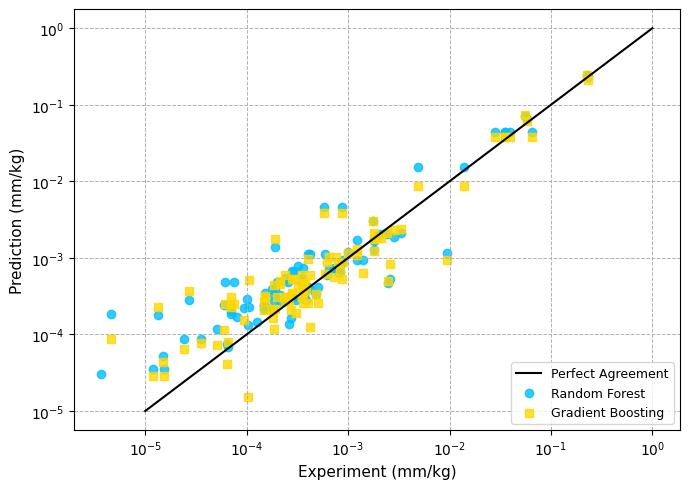

In [24]:
import matplotlib.pyplot as plt
import numpy as np

Y_true = Y_test_trees  # Ground truth

plt.figure(figsize=(7, 5))

# Plot perfect agreement line
min_val = 1e-5
max_val = 1
plt.plot([min_val, max_val], [min_val, max_val], 'k-', linewidth=1.5, label='Perfect Agreement')

# Scatter plots for all models
plt.scatter(Y_true, Y_pred_rf,    c='deepskyblue', label='Random Forest',   marker='o', alpha=0.8)

plt.scatter(Y_true, Y_pred_gbr,   c='gold',     label='Gradient Boosting',         marker='s', alpha=0.8)



# first_drop-first_drop scale
plt.xscale('log')
plt.yscale('log')

# Custom ticks
ticks = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
plt.xticks(ticks, [r'$10^{-5}$', r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$'])
plt.yticks(ticks, [r'$10^{-5}$', r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$'])

# Grid
plt.grid(True, which='major', linestyle='--', linewidth=0.7)
plt.minorticks_off()

# Labels and legend
plt.xlabel("Experiment (mm/kg)", fontsize=11)
plt.ylabel("Prediction (mm/kg)", fontsize=11)
plt.legend(loc='lower right', fontsize=9)

plt.tight_layout()
plt.show()



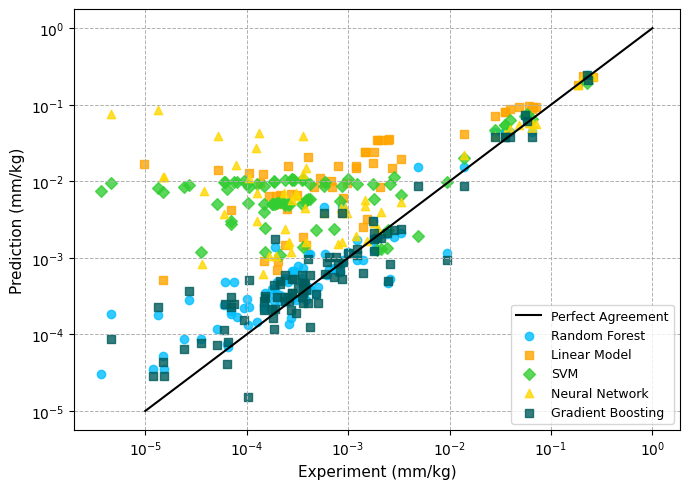

In [25]:
import matplotlib.pyplot as plt
import numpy as np

Y_true = Y_test_first_drop  # Ground truth
Y_nn_LR = Y_test_first_drop_nn_LR
plt.figure(figsize=(7, 5))

# Plot perfect agreement line
min_val = 1e-5
max_val = 1
plt.plot([min_val, max_val], [min_val, max_val], 'k-', linewidth=1.5, label='Perfect Agreement')

# Scatter plots for all models

plt.scatter(Y_true, Y_pred_rf,    c='deepskyblue', label='Random Forest',   marker='o', alpha=0.8)
plt.scatter(Y_nn_LR, Y_pred_lr,    c='orange',      label='Linear Model',    marker='s', alpha=0.8)
plt.scatter(Y_true, Y_pred_svr,   c='limegreen',   label='SVM',             marker='D', alpha=0.8)
plt.scatter(Y_nn_LR, Y_pred_nn,    c='gold',        label='Neural Network',  marker='^', alpha=0.8)
plt.scatter(Y_true, Y_pred_gbr,   c="#005D5D",     label='Gradient Boosting',         marker='s', alpha=0.8)

# first_drop-first_drop scale
plt.xscale('log')
plt.yscale('log')

# Custom ticks
ticks = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
plt.xticks(ticks, [r'$10^{-5}$', r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$'])
plt.yticks(ticks, [r'$10^{-5}$', r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$'])

# Grid
plt.grid(True, which='major', linestyle='--', linewidth=0.7)
plt.minorticks_off()

# Labels and legend
plt.xlabel("Experiment (mm/kg)", fontsize=11)
plt.ylabel("Prediction (mm/kg)", fontsize=11)
plt.legend(loc='lower right', fontsize=9)

plt.tight_layout()
plt.show()
